In [1]:
import sys
from pathlib import Path

# Add the root project folder to the python path in order to use the packages
#path_root = Path( '/project_ghent/HADSP/hadsp/')
#sys.path.append(str(path_root))

In [2]:
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt
from seaborn import heatmap, color_palette

# Datasets loading

Lots of different on availabale : https://towardsdatascience.com/a-data-lakes-worth-of-audio-datasets-b45b88cd4ad

Classification: 
https://arxiv.org/abs/1803.07870

https://github.com/FilippoMB/Time-series-classification-and-clustering-with-Reservoir-Computing

Multivariate:
https://www.timeseriesclassification.com/dataset.php

## Torchaudio

https://pytorch.org/audio/stable/datasets.html


## Prediction ahead

Datasets available :

* MackeyGlass
* Lorenz

## Classification

Datasets available :

* FSDD
* HAART
* JapaneseVowels

Number of audio files: 3000


  0%|                                                                          | 0/3000 [00:00<?, ?it/s]2024-05-15 16:54:34.996150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3000]
	 [[{{node Placeholder/_0}}]]
2024-05-15 16:54:35.007902: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
100%|████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 11688.65it/s]

Mean sampling rate: 8000.0


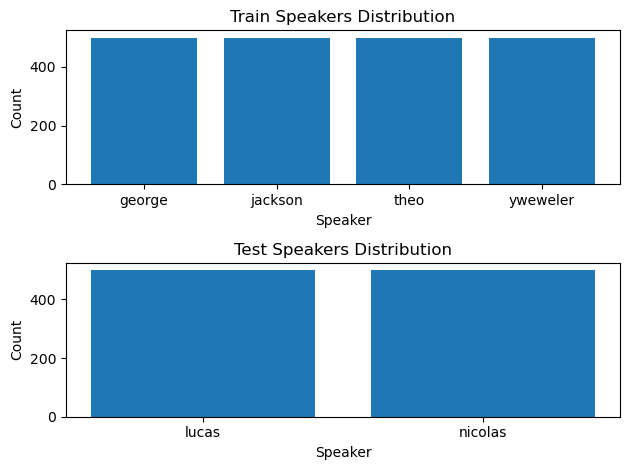

In [3]:
from datasets.load_datasets import load_dataset_classification
is_instances_classification = True
dataset_name = "FSDD"

is_multivariate, sampling_rate, X_train_raw, X_test_raw, Y_train_raw, Y_test, groups = load_dataset_classification(dataset_name)

# Activation function

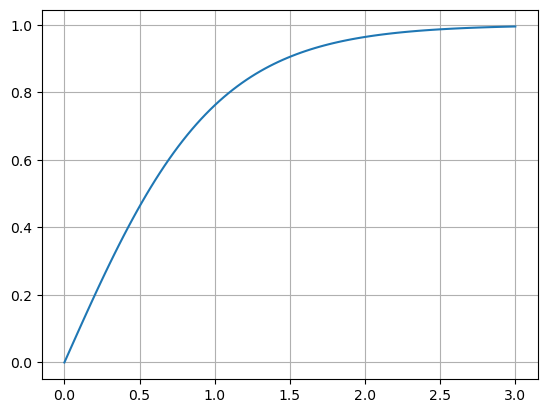

In [6]:
from reservoir.activation_functions import tanh, heaviside, sigmoid

# the activation function choosen for the rest of the experiment
# activation_function = lambda x : sigmoid(2*(x-0.5))tanh(x)
activation_function = lambda x : tanh(x)

plt.plot(np.linspace(0, 3, 100), activation_function(np.linspace(0, 3, 100)))
plt.grid()

# Preprocessing

In [ ]:
import math 
 
# Cross validation
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, StratifiedGroupKFold
from datasets.preprocessing import flexible_indexing

#Preprocessing
from datasets.multivariate_generation import generate_multivariate_dataset, extract_peak_frequencies
from sklearn.preprocessing import MinMaxScaler
from datasets.preprocessing import scale_data
from datasets.preprocessing import add_noise, duplicate_data

# Define noise parameter
noise_std = 0.001

# SEED
SEED = 49387

nb_splits=3
if is_instances_classification:
    if groups is None:
        splits = StratifiedKFold(n_splits=nb_splits, shuffle=True, random_state=SEED).split(X_train_raw, np.argmax(Y_train_raw, axis=1))
    else:
        splits = StratifiedGroupKFold(n_splits=nb_splits, shuffle=True, random_state=SEED).split(X_train_raw, np.argmax(Y_train_raw, axis=1), groups)
else: #prediction
    splits = TimeSeriesSplit(n_splits=nb_splits).split(X_train_raw)

X_pretrain = []
X_pretrain_noisy  = []
X_train = []
X_train_noisy = []
X_val = []
X_val_noisy = []
X_pretrain_band = []
X_pretrain_band_noisy = []
X_train_band = []
X_train_band_noisy = []
X_val_band = []
X_val_band_noisy = []

Y_train = []
Y_val = []

WINDOW_LENGTH = 10
freq_train_data = X_train_raw
flat_train_data = np.concatenate(freq_train_data, axis=0) if is_instances_classification else freq_train_data
extract_peak_frequencies(flat_train_data, sampling_rate, smooth=True, window_length=WINDOW_LENGTH, threshold=1e-5, nperseg=1024, visualize=True)

for i, (train_index, val_index) in enumerate(splits):
    x_train = flexible_indexing(X_train_raw, train_index)
    x_val = flexible_indexing(X_train_raw, val_index)
    Y_train.append(flexible_indexing(Y_train_raw, train_index))
    Y_val.append(flexible_indexing(Y_train_raw, val_index))
    # SPLITS
    if is_multivariate:
        x_train_band, x_val_band = x_train, x_val
        del x_train, x_val

        
    # PREPROCESSING        
    freq_train_data = x_train_band if is_multivariate else x_train
    flat_train_data = np.concatenate(freq_train_data, axis=0) if is_instances_classification else freq_train_data
    filtered_peak_freqs = extract_peak_frequencies(flat_train_data, sampling_rate, smooth=True, window_length=WINDOW_LENGTH, threshold=1e-5, nperseg=1024, visualize=False)
    
    if not is_multivariate:
        common_size = len(filtered_peak_freqs)
        x_train_band = generate_multivariate_dataset(
            filtered_peak_freqs, x_train, sampling_rate, is_instances_classification, nb_jobs=-1
        )
        x_val_band = generate_multivariate_dataset(
            filtered_peak_freqs, x_val, sampling_rate, is_instances_classification, nb_jobs=-1
        )

    if not is_multivariate:
        scaler_x_uni = MinMaxScaler(feature_range=(0, 1))
        x_train, x_val, _ = scale_data(x_train, x_val, None, scaler_x_uni, is_instances_classification)       
        X_train.append(x_train)
        X_val.append(x_val)

    scaler_multi = MinMaxScaler(feature_range=(0, 1))
    x_train_band, x_val_band, _ = scale_data(x_train_band, x_val_band, None, scaler_multi, is_instances_classification)
    X_train_band.append(x_train_band)
    X_val_band.append(x_val_band)
             
    # PRETRAIN NOISE
    # UNI
    if not is_multivariate:
        X_pretrain.append(x_train.flatten())
        X_pretrain_noisy.append((add_noise(x_train, noise_std)).flatten())
    
    # MULTI
    X_pretrain_band.append(x_train_band)
    X_pretrain_band_noisy.append([add_noise(instance, noise_std) for instance in X_pretrain_band[i]])
    
    #Train/Val/Test
    if is_instances_classification:
        # NOISE
        # UNI
        if not is_multivariate:
            X_train_noisy.append([add_noise(instance, noise_std) for instance in x_train])
            X_val_noisy.append([add_noise(instance, noise_std) for instance in x_val])
            
        # MULTI
        X_train_band_noisy.append([add_noise(instance, noise_std) for instance in x_train_band])
        X_val_band_noisy.append([add_noise(instance, noise_std) for instance in x_val_band])
    
    else:  #if prediction
        # NOISE
        # UNI
        if not is_multivariate:
            X_train_noisy.append(add_noise(x_train, noise_std))
            X_val_noisy.append(add_noise(x_val, noise_std))
    
        # MULTI
        X_train_band_noisy.append(add_noise(x_train_band, noise_std))
        X_val_band_noisy.append(add_noise(x_val_band, noise_std))
        


# Hyperparameter search

In [ ]:
from joblib import Parallel, delayed

#Pretraining
from reservoir.reservoir import init_matrices
from connexion_generation.bounded_hadsp import run_hadsp_algorithm
from connexion_generation.desp import run_desp_algorithm

# Evaluating
from performances.esn_model_evaluation import init_and_train_model_for_classification, predict_model_for_classification, compute_score
from performances.esn_model_evaluation import init_and_train_model_for_prediction


# score for prediction
start_step = 30
end_step = 500
SLICE_RANGE = slice(start_step, end_step)
RESERVOIR_SIZE = 500

function_name = "desp" # "desp" ou "hadsp" or "random"
data_type = "normal" # "normal" ou "noisy"
variate_type = "multi" # "multi" ou "uni"
if variate_type == "uni" and is_multivariate:
    raise ValueError(f"Invalid variable type: {variate_type}")
    

def objective(trial):
    # Suggest values for the parameters you want to optimize
    # COMMON
    input_scaling = trial.suggest_float('input_scaling', 0.01, 0.2, step=0.005)
    bias_scaling = trial.suggest_float('bias_scaling', 0, 0.2, step=0.01)
    leaky_rate = trial.suggest_float('leaky_rate', 1, 1)
    input_connectivity = trial.suggest_float('input_connectivity', 1, 1)
    network_size = trial.suggest_int('network_size', RESERVOIR_SIZE, RESERVOIR_SIZE)
    weight_increment = trial.suggest_float('weight_increment', 0.01, 0.5, step=0.01)
    max_partners = trial.suggest_int('network_size', 12, 20)

    ridge = trial.suggest_int('ridge', -15, 1)
    RIDGE_COEF = 10**ridge

    min_window_size = sampling_rate/np.max(np.hstack(filtered_peak_freqs))
    max_window_size = sampling_rate/np.min(np.hstack(filtered_peak_freqs))

    # HADSP
    if function_name == "hadsp":
        connectivity = trial.suggest_float('connectivity', 0, 0)
        target_rate = trial.suggest_float('target_rate', 0.5, 1, step=0.01)
        rate_spread = trial.suggest_float('rate_spread', 0.01, 0.4, step=0.005)
        TIME_INCREMENT = int(min_window_size+1) # int(min_window_size+1) or int(max_window_size)
        MAX_TIME_INCREMENT = int(max_window_size) #int(max_window_size) or None or TIME_INCREMENT
    # DESP
    elif function_name == "desp":
        connectivity = trial.suggest_float('connectivity', 0, 0)
        variance_target = trial.suggest_float('min_variance', 0.001, 0.02, step=0.001)
        variance_spread = trial.suggest_float('variance_window', 0.01, 0.05, step=0.002)
        TIME_INCREMENT = 50 # int(min_window_size+1) or int(max_window_size)
        MAX_TIME_INCREMENT = TIME_INCREMENT #int(max_window_size) or None or TIME_INCREMENT
    elif function_name == "random":
        connectivity = trial.suggest_float('connectivity', 0, 1)
        sr = trial.suggest_float('spectral_radius', 0.4, 1.6, step=0.01)
    else:
        raise ValueError(f"Invalid function name: {function_name}")
        
    if int(max_window_size) < TIME_INCREMENT or TIME_INCREMENT < min_window_size:
        raise ValueError(f"INCREMENT must be greater than {min_window_size} and smaller than {max_window_size}. Current INCREMENT is {TIME_INCREMENT}.")


    # CROSS-VALIDATION METHODS
    total_score = 0
    for i in range(nb_splits):
        if variate_type == "multi":
            if is_instances_classification:
                common_index = 1
                common_size = X_train_band[i][0].shape[common_index]
            else:
                common_index = 1
                common_size = X_train_band[i].shape[common_index]
        else:
            common_size = len(filtered_peak_freqs)
            
        # We want the size of the reservoir to be at least network_size
        K = math.ceil(network_size / common_size)
        n = common_size * K


        pretrain_data = X_pretrain_band[i]
        train_data = X_train_band[i]  # X_train_band_noisy_duplicated or X_train_band_duplicated
        val_data = X_val_band_noisy[i] if data_type == "noisy" else X_val_band[i]

        # UNSUPERVISED PRETRAINING 
        Win, W, bias = init_matrices(n, input_connectivity, connectivity,  K)
        bias *= bias_scaling
        Win *= input_scaling

        if function_name == "hadsp":
            W, _ = run_hadsp_algorithm(W, Win, bias, leaky_rate, activation_function, training_set, TIME_INCREMENT, WEIGHT_INCREMENT,
                            target_rate, rate_spread, instances=is_instances_classification, max_increment=MAX_TIME_INCREMENT, max_partners=max_partners, method = "random", n_jobs = 1)
        elif function_name == "desp":
            W, _, _ = run_desp_algorithm(W, Win, bias, leaky_rate, activation_function, training_set, TIME_INCREMENT, WEIGHT_INCREMENT,
                            variance_target, variance_spread, instances=is_instances_classification, max_increment=MAX_TIME_INCREMENT, max_partners=12, method = "mi", n_jobs = 4)
        elif function_name == "random":
            eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
            W *= spectral_radius / max(abs(eigen))
        else:
            raise ValueError(f"Invalid function: {function_name}")
        

        # TRAINING and EVALUATION
        if is_instances_classification:
            reservoir, readout = init_and_train_model_for_classification(W, Win, bias, leaky_rate, activation_function, train_data, Y_train[i], n_jobs = 4, ridge_coef=RIDGE_COEF, mode="sequence-to-vector")
            
            Y_pred = predict_model_for_classification(reservoir, readout, val_data, n_jobs = 4)
            score = compute_score(Y_pred, Y_val[i], is_instances_classification)
        else:
            esn = init_and_train_model_for_prediction(W, Win, bias, leaky_rate, activation_function, train_data, Y_train[i], RIDGE_COEF)
            
            Y_pred =  esn.run(val_data, reset=False)
            score = compute_score(Y_pred, Y_val[i], is_instances_classification)

        total_score += score

    average_score = total_score / nb_splits  # Average the score

    return average_score


In [ ]:
import optuna
from optuna.samplers import TPESampler
import re

def camel_to_snake(name):
    str1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', str1).lower()

url= "sqlite:///optuna_" + camel_to_snake(dataset_name) + "_db.sqlite3"
print(url)
storage = optuna.storages.RDBStorage(
    url=url,
    engine_kwargs={"pool_size": 20, "connect_args": {"timeout": 10}},
)
study_name = function_name + "_" + dataset_name + "_" + data_type + "_" + variate_type
print(study_name)
direction = "maximize" if is_instances_classification else "minimize"
sampler = TPESampler()

def optimize_study(n_trials):
    study = optuna.create_study(storage=storage, sampler=sampler, study_name=study_name, direction=direction, load_if_exists=True)
    study.optimize(objective, n_trials=n_trials)

N_TRIALS = 400
n_parallel_studies = 2
trials_per_process = N_TRIALS // n_parallel_studies

# Use joblib to parallelize the optimization
Parallel(n_jobs=n_parallel_studies)(
    delayed(optimize_study)(trials_per_process) for _ in range(n_parallel_studies)
)


# Results



## Mackey Glass
### Ridge parameter
| Dataset     | Algorithm | test   | Curve shape | Best value |
|-------------|-----------|--------|-------------|------------|
| MackeyGlass | DESP      | normal | no extremum | 10         |
| MackeyGlass | HADSP     | normal | no extremum | 9,10       |
| MackeyGlass | random    | normal | no extremum | 9,10       |
| MackeyGlass | DESP      | noisy  | bell        | 7          |
| MackeyGlass | HADSP     | noisy  | bell        | 6          |
| MackeyGlass | random    | noisy  | no extremum | 10         |

### Results, no validation/test

|           |  HADSP |  DESP  | random |
|-----------|--------|--------|--------|
|  normal   | 0.0399 | 0.0379 | 0.0446 |
|  noisy    | 0.119  | 0.109  | 0.104  | 


## Japanese vowels

### Ridge parameter

| Dataset        | Algorithm | test   | Curve shape | Best value |
|----------------|-----------|--------|-------------|------------|
| JapaneseVowels | DESP      | normal | bell        | 2          |
| JapaneseVowels | HADSP     | normal | bell        | 4          |
| JapaneseVowels | random    | normal | bell        | 4          |
| JapaneseVowels | DESP      | noisy  | bell        | 2          |
| JapaneseVowels | HADSP     | noisy  | bell        | 5          |
| JapaneseVowels | random    | noisy  | bell        | 5          |

### Results, no validation/test

|           |  HADSP |  DESP  | random |
|-----------|--------|--------|--------|
|  normal   | 0.641  | 0.649  | 0.612  |
|  noisy    | 0.621  | 0.623  | 0.610  | 